* We will cover high level explanation of sequence models in Deep Learning
* Will spend most of our time exploring data preparation for LSTM
* Discuss few basic LSTM architectures and how they work

![]( images/timesequence.png)

Types of Sequence Model
![]( images/oto_otm.png)

![]( images/mto_mtm.png)


### Preparing the data


** It's helpful to think ahead about what type of sequence formulation we need, in order to create the right input and output shapes**

1. The Input to an LSTM layer is expected to be a 3D Matrix/Tensor. `(Number of input sequences, Sequence Length, Number of Features)`

2. The default output of LSTM layer is a 2 D Matrix

3. If our output is not a sequence,  then output shape is 2D. `(number of instances,number of target variables)`




### Preparing the data

1. For this dataset we want to use 5 days historical weather data to forecast one temperature reading 24 hours later
2. The frequency of those sensor readings is every 10 minutes, we will resample it to median hourly value
<div class="alert alert-block alert-danger">
We need to normalize the data by fitting a standard scaler on training and applying it on all the data </div> 
4. We will write a function that will return lists of training, validation, and test datasets

import pandas as pd
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf;

In [150]:
'''
re-Importing weather data
'''
weather_df=pd.read_csv('allWeather.csv')

**Downsample the data from reading every 10 minute set to median reading every hour**
1. We need to make time stamp colunm as index
2. remove old index
3. use Pandas resample function to get the hourly median

In [3]:
weather_df=weather_df.set_index(pd.DatetimeIndex(weather_df['Date Time']))

In [4]:
weather_df=weather_df.drop('Unnamed: 0',axis=1)

In [6]:
'''
resample function will apply a groupby aggregation to the desired sampling period. in this case 60T will yield an hour
'''
weather_grpd=weather_df.resample('60T').median()

In [7]:
weather_grpd

,CO2 (ppm),H2OC (mmol/mol),PAR (?mol/m?/s),SWDR (W/m?),T (degC),Tdew (degC),Tlog (degC),Tpot (K),VPact (mbar),VPdef (mbar),...,max. PAR (?mol/m?/s),max. wv (m/s),p (mbar),rain (mm),raining (s),rh (%),rho (g/m**3),sh (g/kg),wd (deg),wv (m/s)
Date Time,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,404.10,4.890,0.000,0.000,-2.880,-3.460,8.540,272.850,4.730,0.210,...,0.000,3.770,967.450,0.00,0.0,95.800,1244.570,3.050,18.940,2.250
2010-01-01 01:00:00,402.40,4.840,0.000,0.000,-3.045,-3.590,8.440,272.710,4.680,0.190,...,0.000,4.210,967.115,0.00,50.0,96.150,1245.015,3.020,22.560,2.765
2010-01-01 02:00:00,402.25,4.835,0.000,0.000,-3.105,-3.600,8.310,272.660,4.675,0.180,...,0.000,3.890,967.020,0.00,0.0,96.250,1245.130,3.015,30.785,2.710
2010-01-01 03:00:00,401.60,4.730,0.000,0.000,-3.435,-3.895,8.055,272.320,4.575,0.160,...,0.000,4.970,967.055,0.00,0.0,96.650,1246.760,2.950,38.325,3.605
2010-01-01 04:00:00,399.85,4.640,0.000,0.000,-3.735,-4.150,7.585,272.040,4.490,0.140,...,0.000,4.650,966.785,0.00,0.0,96.900,1247.860,2.895,30.205,3.275
2010-01-01 05:00:00,400.45,4.600,0.000,0.000,-3.900,-4.265,7.330,271.860,4.450,0.120,...,0.000,4.370,966.930,0.05,600.0,97.400,1248.860,2.870,28.530,2.795
2010-01-01 06:00:00,401.45,4.575,0.000,0.000,-3.965,-4.335,7.260,271.790,4.425,0.130,...,0.000,3.760,967.075,0.00,465.0,97.150,1249.300,2.850,27.540,2.725
2010-01-01 07:00:00,402.50,4.575,0.000,0.000,-3.885,-4.335,7.505,271.840,4.425,0.160,...,0.000,2.430,967.410,0.00,0.0,96.550,1249.340,2.850,28.875,1.580
2010-01-01 08:00:00,399.90,4.485,4.250,1.505,-4.015,-4.580,8.030,271.685,4.345,0.190,...,6.370,2.700,967.730,0.00,175.0,95.800,1250.420,2.795,14.930,1.635


In [8]:
weather_grpd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78288 entries, 2010-01-01 00:00:00 to 2018-12-06 23:00:00
Freq: 60T
Data columns (total 21 columns):
CO2 (ppm)               74150 non-null float64
H2OC (mmol/mol)         74150 non-null float64
PAR (?mol/m?/s)         74150 non-null float64
SWDR (W/m?)             74150 non-null float64
T (degC)                74150 non-null float64
Tdew (degC)             74150 non-null float64
Tlog (degC)             74150 non-null float64
Tpot (K)                74150 non-null float64
VPact (mbar)            74150 non-null float64
VPdef (mbar)            74150 non-null float64
VPmax (mbar)            74150 non-null float64
max. PAR (?mol/m?/s)    74150 non-null float64
max. wv (m/s)           74150 non-null float64
p (mbar)                74150 non-null float64
rain (mm)               74150 non-null float64
raining (s)             74150 non-null float64
rh (%)                  74150 non-null float64
rho (g/m**3)            74150 non-null float64


In [9]:
'''Just in case we have any missing values, we will use forward fill to take care of that'''
weather_grpd=weather_grpd.fillna(method='ffill')

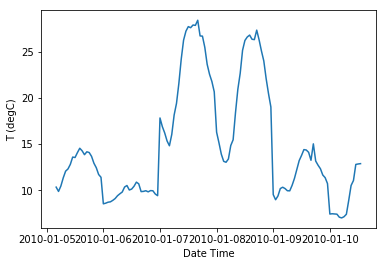

In [161]:
sns.lineplot(x=weather_grpd.iloc[100:230,:].index,y="T (degC)",data=weather_grpd.iloc[100:230,:])
plt.show();

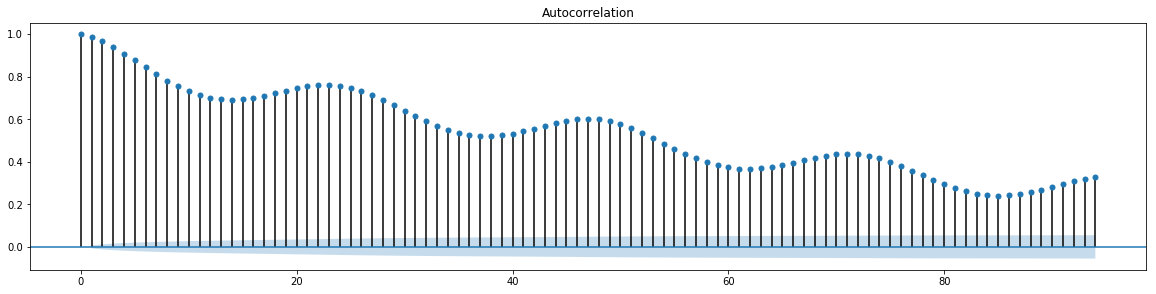

In [153]:
fig=plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(weather_grpd["T (degC)"].values.squeeze(),lags=94,ax=ax1)
plt.show();


The Graph above shows strong correlations between temperature lags

In [10]:
print('Data Length:', len(weather_grpd))
print('number of rows to truncate:', len(weather_grpd)%24)
print("Total number of days:", len(weather_grpd)//24)

Data Length: 78288
number of rows to truncate: 0
Total number of days: 3262


* This dataset starts in 2010, we will have the last 162 days as test set and 200 days for validation
* The code below generates our indices for validation and testing

In [115]:
lengthindays=len(weather_grpd)//24
valdays=200
testdays=162
test_index=(lengthindays-testdays)*24 # taking the last 262 days to forecast on
val_index=(lengthindays-testdays-valdays)*24

Given the differing scale of the data, it's highly recommended to **Normalize data on training set**

In [12]:
scaler=StandardScaler()

In [13]:
'''We will fit on training data only, but then transform the entire data set'''
scaler=scaler.fit(weather_grpd.iloc[:val_index,:].values)

In [14]:
'''Transforming the entire dataset'''
weather_scaled=pd.DataFrame(scaler.transform(weather_grpd),columns=weather_grpd.columns,index=weather_grpd.index)

In [15]:
weather_scaled

,CO2 (ppm),H2OC (mmol/mol),PAR (?mol/m?/s),SWDR (W/m?),T (degC),Tdew (degC),Tlog (degC),Tpot (K),VPact (mbar),VPdef (mbar),...,max. PAR (?mol/m?/s),max. wv (m/s),p (mbar),rain (mm),raining (s),rh (%),rho (g/m**3),sh (g/kg),wd (deg),wv (m/s)
Date Time,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,0.038063,-1.134108,-0.611904,-0.606340,-1.497416,-1.278287,-1.608309,-1.276513,-1.161415,-0.794058,...,-0.602021,0.010513,-2.671223,-0.126755,-0.300131,1.224124,0.724164,-1.131581,-1.982989,0.008715
2010-01-01 01:00:00,0.034861,-1.145842,-0.611904,-0.606340,-1.517162,-1.297715,-1.620743,-1.293059,-1.173298,-0.798143,...,-0.602021,0.017210,-2.711759,-0.126755,0.048612,1.245514,0.735294,-1.142807,-1.937103,0.016557
2010-01-01 02:00:00,0.034579,-1.147015,-0.611904,-0.606340,-1.524342,-1.299209,-1.636907,-1.298968,-1.174486,-0.800186,...,-0.602021,0.012340,-2.723254,-0.126755,-0.300131,1.251625,0.738170,-1.144678,-1.832844,0.015720
2010-01-01 03:00:00,0.033354,-1.171656,-0.611904,-0.606340,-1.563833,-1.343296,-1.668615,-1.339150,-1.198251,-0.804271,...,-0.602021,0.028776,-2.719019,-0.126755,-0.300131,1.276071,0.778938,-1.169000,-1.737268,0.029347
2010-01-01 04:00:00,0.030058,-1.192777,-0.611904,-0.606340,-1.599734,-1.381405,-1.727055,-1.372241,-1.218451,-0.808356,...,-0.602021,0.023906,-2.751690,-0.126755,-0.300131,1.291350,0.806449,-1.189580,-1.840196,0.024322
2010-01-01 05:00:00,0.031188,-1.202164,-0.611904,-0.606340,-1.619479,-1.398591,-1.758762,-1.393514,-1.227957,-0.812441,...,-0.602021,0.019645,-2.734145,0.921755,3.884785,1.321908,0.831460,-1.198935,-1.861428,0.017014
2010-01-01 06:00:00,0.033072,-1.208030,-0.611904,-0.606340,-1.627258,-1.409052,-1.767466,-1.401787,-1.233898,-0.810399,...,-0.602021,0.010361,-2.716599,-0.126755,2.943179,1.306629,0.842464,-1.206418,-1.873977,0.015948
2010-01-01 07:00:00,0.035050,-1.208030,-0.611904,-0.606340,-1.617684,-1.409052,-1.737003,-1.395878,-1.233898,-0.804271,...,-0.602021,-0.009880,-2.676063,-0.126755,-0.300131,1.269960,0.843465,-1.206418,-1.857055,-0.001486
2010-01-01 08:00:00,0.030153,-1.229151,-0.601130,-0.598923,-1.633241,-1.445667,-1.671723,-1.414196,-1.252910,-0.798143,...,-0.589107,-0.005771,-2.637342,-0.126755,0.920470,1.224124,0.870476,-1.226999,-2.033819,-0.000649


We stopped and asked random people on the street to guess what the temperature will be in 24 hours. It's likely they will guess it to be the same as the current hour. 

We're going to call that the casual observer model. This model is lazy and assumes the temperature is the same value it was 24 hours ago. 

This is kind of our floor benchmark that a learning algorithm has to beat.

In [322]:
def casual_observer(series,step):
    ypred=[series.iloc[i-step] for i in range(step,len(series))]
    actual=[series.iloc[i+step] for i in range(len(series)-step)]
    return (np.asarray(ypred).reshape(-1,1),np.asarray(actual).reshape(-1,1))    

We will use Mean Absolute Error function from Scikit learn on the validation data

In [331]:
temp_naive,actual=casual_observer(weather_grpd['T (degC)'].iloc[val_index:test_index],24)
casual_error=mean_absolute_error(actual,temp_naive)
print('simple prediction Error:',casual_error)#/len(weather_grpd['T (degC)'].iloc[val_index:test_index]))

simple prediction loss: 3.26272927136


**This is the function that we will use. It returns list of `samples and targets` for train, val and test**

`samples` is one sequence of input data and 
`targets` is the corresponding array of target temperatures. This function needs the following input:

* `df`: The scaled dataframe from above
* `y_var`: y_var label, this will be a string
* `hist`: is an integer for the number of days lag or looback
* `frcst`: is an integer for the number of days forward for forecast
* `frcst_step`: this is an integer for how many hours to forecast
* `Val`: is the index for Validation set 
* `test`: is the index for test

In [301]:
def seq_prep(df,y_var,hist,frcst,frcst_step,val,test):
    '''
    inputs:
    df: DataFrame that contains X, y variables
    y_var: y_var label, this will be a string
    hist: is an integer for the number of days lag
    frcst: is an integer for the number of days forward for forecast
    frcst_step: this is an integer for how many hours to forecast   
    Val: is the index for Validation
    test: is the index for test
    
    outputs:
    train_seqx: List of Arrays containing the training X input. The shape per array should be (24*hist,number of columns in df)
    train_seqy: List of Arrays containing the training y (label), the shape per array should be (24*fore,)
    val_seqx: List of Arrays containing the valdiation X input. The shape per array should be (24*hist,number of columns in df)
    val_seqy: List of Arrays containing the validation y (label), the shape per array should be (24*fore,)
    test_seqx: List of Arrays containing the test X input. The shape per array should be (24*hist,number of columns in df)
    test_seqy: List of Arrays containing the test y (label), the shape per array should be (24*fore,)
    '''
    train_seqx=[]
    train_seqy=[]
    val_seqx=[]
    val_seqy=[]
    test_seqx=[]
    test_seqy=[]
    train_df=df.iloc[:val,:]
    val_df=df.iloc[val:test,:]
    test_df=df.iloc[test:,:]
    train_x_arr=train_df.values
    train_y_arr=train_df[y_var].values
    val_x_arr=val_df.values
    val_y_arr=val_df[y_var].values
    test_x_arr=test_df.values
    test_y_arr=test_df[y_var].values
    hist_seq=24*hist # turning history into 24 hour x number of days vector
    fore_seq=24*frcst
    seq_len=(hist_seq+fore_seq)
    
    for i in range(len(train_y_arr)):
        if i+seq_len<len(train_y_arr):
            train_seqx.append(train_x_arr[i:i+hist_seq,:])
            train_seqy.append(train_y_arr[i+hist_seq:i+seq_len][:frcst_step])         
       
        else:
            val_index_add=i            
            break
            
            
    val_x_arr=np.insert(val_x_arr,0,train_x_arr[val_index_add:,:],axis=0)
    val_y_arr=np.insert(val_y_arr,0,train_y_arr[val_index_add:],axis=0)
    for i in range(len(val_y_arr)):
        if i+seq_len<len(val_y_arr):
            val_seqx.append(val_x_arr[i:i+hist_seq,:])
            val_seqy.append(val_y_arr[i+hist_seq:i+seq_len][:frcst_step])       
       
        else:
            test_index_add=i            
            break
             
    test_x_arr=np.insert(test_x_arr,0,val_x_arr[test_index_add:,:],axis=0)
    test_y_arr=np.insert(test_y_arr,0,val_y_arr[test_index_add:],axis=0)
    for i in range(len(test_y_arr)):
        if i+seq_len<len(test_y_arr):
            test_seqx.append(test_x_arr[i:i+hist_seq,:])
            test_seqy.append(test_y_arr[i+hist_seq:i+seq_len][:frcst_step])   
    
            
    return train_seqx,train_seqy,val_seqx,val_seqy,test_seqx,test_seqy

In [302]:
train_X_list, train_y_list,val_X_list, val_y_list,test_X_list, test_y_list=seq_prep(weather_scaled,
                                                                                    "T (degC)",5,1,1,val_index,test_index)

In [303]:
train_X_list[0]

array([[  3.80632120e-02,  -1.13410778e+00,  -6.11904272e-01, ...,
         -1.13158144e+00,  -1.98298936e+00,   8.71538700e-03],
       [  3.48612835e-02,  -1.14584153e+00,  -6.11904272e-01, ...,
         -1.14280698e+00,  -1.93710284e+00,   1.65569497e-02],
       [  3.45787604e-02,  -1.14701490e+00,  -6.11904272e-01, ...,
         -1.14467790e+00,  -1.83284410e+00,   1.57195013e-02],
       ..., 
       [  2.63855904e-02,   1.80071919e-01,  -6.11904272e-01, ...,
          1.79935466e-01,   8.71735214e-01,  -1.86691607e-03],
       [  3.43904117e-02,   1.87112168e-01,  -6.11904272e-01, ...,
          1.85548235e-01,   6.53710870e-01,  -1.00130055e-02],
       [  2.77982059e-02,   5.45208231e-02,  -6.11904272e-01, ...,
          5.27127133e-02,   8.02651919e-01,   6.96435843e-03]])

In [304]:
train_y_list[0]

array([-0.13138847])

In [305]:
print('Shape of input sequence:',train_X_list[0].shape)
print('Shape of output sequence:',train_y_list[0].shape)

Shape of input sequence: (120, 21)
Shape of output sequence: (1,)


In [306]:
from keras.preprocessing import sequence

* Now we have list of samples, where each imput sample is `(120, 14)` and each output sample is `(1,)`
* We will need to turn this list of samples into legitimate 3D/2D tensors. For that we will use Keras sequence generator built-in function

In [307]:
'''Defining the sequence lengths for both input and output'''
X_seqlen=train_X_list[0].shape[0]
y_seqlen=train_y_list[0].shape[0]

In [308]:
'''
pad_sequences function is a very versatile function. it allows us to handle cases 
of uneven sequence length by padding or truncating to a specificed length.
Default pad value is 0, but user can apply any number or pass an impute into it

'''
train_X_seq = sequence.pad_sequences(train_X_list, dtype='float32', maxlen=X_seqlen, padding='post',truncating='post')
train_y_seq = sequence.pad_sequences(train_y_list,dtype='float32',maxlen=y_seqlen, padding='post',truncating='post')
val_X_seq = sequence.pad_sequences(val_X_list, dtype='float32', maxlen=X_seqlen, padding='post',truncating='post')
val_y_seq = sequence.pad_sequences(val_y_list,dtype='float32',maxlen=y_seqlen, padding='post',truncating='post')
test_X_seq = sequence.pad_sequences(test_X_list, dtype='float32', maxlen=X_seqlen, padding='post',truncating='post')
test_y_seq = sequence.pad_sequences(test_y_list,dtype='float32',maxlen=y_seqlen, padding='post',truncating='post')

In [309]:
'''WE got our Tensors'''
print('X shape:', train_X_seq.shape)
print('y shape:',train_y_seq.shape)

X shape: (69456, 120, 21)
y shape: (69456, 1)


In [310]:
BATCH_SIZE=128
NUM_TIMESTEPS=train_X_seq.shape[1]
features=train_X_seq.shape[2]
output=train_y_seq.shape[1]

In [311]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.optimizers import RMSprop

We're going to start with a vanilla LSTM network:
    - Single Layer
    - No dropout

In [339]:
model = Sequential()
'''The input to an LSTM layer has to be 3D tensor. The default LSTM layer output is 2D '''
model.add(LSTM(32, input_shape=(NUM_TIMESTEPS,features )))## The shape of each input sample is defined in 1st layer only
model.add(Dense(output))
model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 32)                6912      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 6,945
Trainable params: 6,945
Non-trainable params: 0
_________________________________________________________________


In [340]:
history=model.fit(train_X_seq,train_y_seq,epochs=10,shuffle=False,batch_size=BATCH_SIZE,validation_data=(val_X_seq,val_y_seq))

Train on 69456 samples, validate on 4800 samples
Epoch 1/10
69456/69456 [==============================] - 90s - loss: 0.1393 - val_loss: 0.0802
Epoch 2/10
69456/69456 [==============================] - 102s - loss: 0.0778 - val_loss: 0.0634
Epoch 3/10
69456/69456 [==============================] - 105s - loss: 0.0720 - val_loss: 0.0659
Epoch 4/10
69456/69456 [==============================] - 106s - loss: 0.0698 - val_loss: 0.0600
Epoch 5/10
69456/69456 [==============================] - 105s - loss: 0.0685 - val_loss: 0.0645
Epoch 6/10
69456/69456 [==============================] - 102s - loss: 0.0677 - val_loss: 0.0588
Epoch 7/10
69456/69456 [==============================] - 102s - loss: 0.0666 - val_loss: 0.0681
Epoch 8/10
69456/69456 [==============================] - 103s - loss: 0.0662 - val_loss: 0.0695
Epoch 9/10
69456/69456 [==============================] - 105s - loss: 0.0655 - val_loss: 0.0628
Epoch 10/10
69456/69456 [==============================] - 105s - loss: 0.0650 

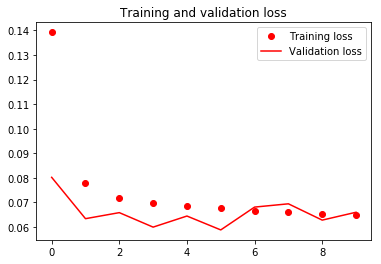

In [341]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_loss))

plt.figure()

plt.plot(epochs, train_loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The Validation and training loss looks balanced and the model does not seem to overfit the training

The mean absolute error is certainly better than our casual observer, so that's good

In [332]:
mean_absolute_error(val_y_seq,model.predict(val_X_seq))

1.1831849

If more capacity is needed from a network, it's good to add more layers and/or add more neurons/cells. Although generally speaking adding layers gets you better capacity to computation ratio

In [336]:
model2 = Sequential()
'''
Input to LSTM layer has to always be 3D, since the output is by default is 2D. We need to make 
return_sequences=True in order to stack a second LSTM layer. 
This will make the output of the 1st LSTM layer return a 3D output, which can now be input to the 2nd LSTM layer
dropout and Recurrent_dropout helps with regularizing the network and reduce overfitting. 
'''
model2.add(LSTM(32, input_shape=(NUM_TIMESTEPS,features ),dropout=0.3, recurrent_dropout=0.5,return_sequences=True))
model2.add(LSTM(64, input_shape=(NUM_TIMESTEPS,features ),dropout=0.3, recurrent_dropout=0.5))
model2.add(Dense(output))
model2.compile(optimizer=RMSprop(), loss='mae')
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 120, 32)           6912      
_________________________________________________________________
lstm_32 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 31,809
Trainable params: 31,809
Non-trainable params: 0
_________________________________________________________________


In [337]:
history2=model2.fit(train_X_seq,train_y_seq,epochs=15,shuffle=False,batch_size=BATCH_SIZE,validation_data=(val_X_seq,val_y_seq))

Train on 69456 samples, validate on 4800 samples
Epoch 1/15
69456/69456 [==============================] - 327s - loss: 0.2856 - val_loss: 0.1392
Epoch 2/15
69456/69456 [==============================] - 22792s - loss: 0.1991 - val_loss: 0.1101
Epoch 3/15
69456/69456 [==============================] - 302s - loss: 0.1708 - val_loss: 0.1046
Epoch 4/15
69456/69456 [==============================] - 293s - loss: 0.1582 - val_loss: 0.0898
Epoch 5/15
69456/69456 [==============================] - 290s - loss: 0.1519 - val_loss: 0.0824
Epoch 6/15
69456/69456 [==============================] - 293s - loss: 0.1468 - val_loss: 0.0838
Epoch 7/15
69456/69456 [==============================] - 307s - loss: 0.1433 - val_loss: 0.0911
Epoch 8/15
69456/69456 [==============================] - 301s - loss: 0.1400 - val_loss: 0.0886
Epoch 9/15
69456/69456 [==============================] - 296s - loss: 0.1380 - val_loss: 0.0953
Epoch 10/15
69456/69456 [==============================] - 303s - loss: 0.13

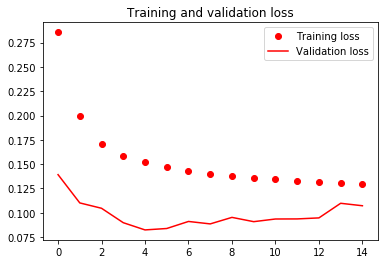

In [338]:
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(train_loss))

plt.figure()

plt.plot(epochs, train_loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<!--NAVIGATION-->
##### <[Collecting the Data](_02_Collecting_Data.ipynb) | [Contents](Index.ipynb) |>